In [1]:
from keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import random

In [2]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
import keras.backend as K

def categorical_focal_loss(alpha, gamma=2.):

    alpha = np.array(alpha, dtype=np.float32)

    def categorical_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred: A tensor resulting from a softmax
        :return: Output tensor.
        """

        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Calculate Cross Entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate Focal Loss
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

        # Compute mean loss in mini_batch
        return K.mean(K.sum(loss, axis=-1))

    return categorical_focal_loss_fixed

In [5]:
# useful for getting number of classes
folders = glob('C:/CKplus/data/train/*')
print("Number of folders,\n",folders)

Number of folders,
 ['C:/Users/wweis/Deep Learning/CKplus/data/train\\anger', 'C:/Users/wweis/Deep Learning/CKplus/data/train\\contempt', 'C:/Users/wweis/Deep Learning/CKplus/data/train\\disgust', 'C:/Users/wweis/Deep Learning/CKplus/data/train\\fear', 'C:/Users/wweis/Deep Learning/CKplus/data/train\\happy', 'C:/Users/wweis/Deep Learning/CKplus/data/train\\sadness', 'C:/Users/wweis/Deep Learning/CKplus/data/train\\surprise']


## Data Augmentation

In [6]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('C:/CKplus/data/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                 shuffle=True,
                                                 seed=42)

validation_set = test_datagen.flow_from_directory(
        'C:/CKplus/data/valid',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=True,
        seed=42)

test_set = test_datagen.flow_from_directory('C:/CKplus/data/test',
                                            target_size = (224, 224),
                                            batch_size=1,
                                            class_mode='categorical',
                                            shuffle=False,
                                            seed=42)

Found 686 images belonging to 7 classes.
Found 98 images belonging to 7 classes.
Found 197 images belonging to 7 classes.


In [7]:
print(len(training_set))
print(len(training_set.classes))

22
686


## Pretrained VGG-16

In [9]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

In [10]:
x = vgg.get_layer('block1_pool').output
coarse_1 = Flatten()(x)
coarse_1 = Dense(64, activation='relu')(coarse_1)
coarse_1 = BatchNormalization()(coarse_1)
coarse_1 = Dropout(0.2)(coarse_1)
c_1_pred = Dense(len(folders), activation='softmax', name='branch_1')(coarse_1)

x = vgg.get_layer('block2_pool').output
coarse_2 = Flatten()(x)
coarse_2 = Dense(64, activation='relu')(coarse_2)
coarse_2 = BatchNormalization()(coarse_2)
coarse_2 = Dropout(0.2)(coarse_2)
c_2_pred = Dense(len(folders), activation='softmax', name='branch_2')(coarse_2)

x = vgg.get_layer('block3_pool').output
coarse_3 = Flatten()(x)
coarse_3 = Dense(64, activation='relu')(coarse_3)
coarse_3 = BatchNormalization()(coarse_3)
coarse_3 = Dropout(0.2)(coarse_3)
c_3_pred = Dense(len(folders), activation='softmax', name='branch_3')(coarse_3)

x = vgg.get_layer('block4_pool').output
coarse_4 = Flatten()(x)
coarse_4 = Dense(64, activation='relu')(coarse_4)
coarse_4 = BatchNormalization()(coarse_4)
coarse_4 = Dropout(0.2)(coarse_4)
c_4_pred = Dense(len(folders), activation='softmax', name='branch_4')(coarse_4)

x = vgg.get_layer('block5_pool').output
fine = Flatten()(x)
fine = Dense(64, activation='relu')(fine)
fine = BatchNormalization()(fine)
fine = Dropout(0.2)(fine)
fine_pred = Dense(len(folders), activation='softmax', name='fine_branch')(fine)

# create a model object
model = Model(inputs=vgg.input, outputs=[c_1_pred, c_2_pred, c_3_pred, c_4_pred, fine_pred])

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________________

In [12]:
model.compile(
  loss='categorical_crossentropy',
#   loss=categorical_focal_loss(alpha=0.25, gamma=2),
  optimizer='adam',
  metrics=['accuracy']
)

## Train the Model

In [14]:
hist = model.fit(
          training_set,
          validation_data=validation_set,
          epochs=20,
          steps_per_epoch=len(training_set),
          validation_steps=len(validation_set),
          verbose=1
)

Epoch 1/20
22/22 [==============================] - 27s 733ms/step - loss: 7.3349 - branch_1_loss: 2.2023 - branch_2_loss: 1.5826 - branch_3_loss: 1.3412 - branch_4_loss: 1.1476 - fine_branch_loss: 1.0611 - branch_1_accuracy: 0.1851 - branch_2_accuracy: 0.4446 - branch_3_accuracy: 0.5219 - branch_4_accuracy: 0.5991 - fine_branch_accuracy: 0.6385 - val_loss: 138.6827 - val_branch_1_loss: 56.6220 - val_branch_2_loss: 46.9870 - val_branch_3_loss: 21.3862 - val_branch_4_loss: 11.3928 - val_fine_branch_loss: 2.2947 - val_branch_1_accuracy: 0.1939 - val_branch_2_accuracy: 0.1327 - val_branch_3_accuracy: 0.1122 - val_branch_4_accuracy: 0.2347 - val_fine_branch_accuracy: 0.5612
Epoch 2/20
22/22 [==============================] - 10s 438ms/step - loss: 4.9095 - branch_1_loss: 1.8578 - branch_2_loss: 1.0556 - branch_3_loss: 0.8214 - branch_4_loss: 0.6294 - fine_branch_loss: 0.5454 - branch_1_accuracy: 0.3090 - branch_2_accuracy: 0.6866 - branch_3_accuracy: 0.7362 - branch_4_accuracy: 0.8294 - fi

## Plot the loss and accuracy

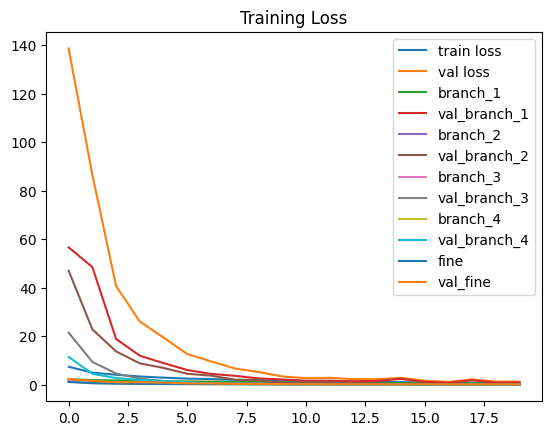

In [15]:
# loss
plt.title('Training Loss')
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='val loss')
plt.plot(hist.history['branch_1_loss'], label='branch_1')
plt.plot(hist.history['val_branch_1_loss'], label='val_branch_1')
plt.plot(hist.history['branch_2_loss'], label='branch_2')
plt.plot(hist.history['val_branch_2_loss'], label='val_branch_2')
plt.plot(hist.history['branch_3_loss'], label='branch_3')
plt.plot(hist.history['val_branch_3_loss'], label='val_branch_3')
plt.plot(hist.history['branch_4_loss'], label='branch_4')
plt.plot(hist.history['val_branch_4_loss'], label='val_branch_4')
plt.plot(hist.history['fine_branch_loss'], label='fine')
plt.plot(hist.history['val_fine_branch_loss'], label='val_fine')
plt.legend()
plt.show()

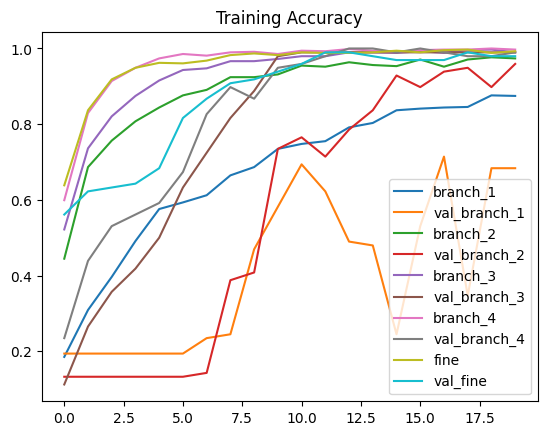

In [16]:
# for i in range(3,8):
#     plt.plot(hist.history['dense_'+str(i)+'_accuracy'], label='dense_'+str(i)+'_accuracy')
#     plt.plot(hist.history['val_dense_'+str(i)+'_accuracy'], label='val_dense_'+str(i)+'_accuracy')
# plt.legend()
# plt.show()

# accuracy
plt.title('Training Accuracy')
plt.plot(hist.history['branch_1_accuracy'], label='branch_1')
plt.plot(hist.history['val_branch_1_accuracy'], label='val_branch_1')
plt.plot(hist.history['branch_2_accuracy'], label='branch_2')
plt.plot(hist.history['val_branch_2_accuracy'], label='val_branch_2')
plt.plot(hist.history['branch_3_accuracy'], label='branch_3')
plt.plot(hist.history['val_branch_3_accuracy'], label='val_branch_3')
plt.plot(hist.history['branch_4_accuracy'], label='branch_4')
plt.plot(hist.history['val_branch_4_accuracy'], label='val_branch_4')
plt.plot(hist.history['fine_branch_accuracy'], label='fine')
plt.plot(hist.history['val_fine_branch_accuracy'], label='val_fine')
plt.legend()
plt.show()

## Model Evaluation / Prediction (test_set)

In [20]:
score_test = model.evaluate(test_set)

197/197 [==============================] - 5s 25ms/step - loss: 1.0833 - branch_1_loss: 0.8205 - branch_2_loss: 0.1450 - branch_3_loss: 0.0552 - branch_4_loss: 0.0329 - fine_branch_loss: 0.0298 - branch_1_accuracy: 0.7157 - branch_2_accuracy: 0.9746 - branch_3_accuracy: 0.9898 - branch_4_accuracy: 0.9949 - fine_branch_accuracy: 0.9949


197/197 [==============================] - 4s 20ms/step
Accuracy for label anger: 0.85
Accuracy for label contempt: 1.00
Accuracy for label disgust: 0.78
Accuracy for label fear: 0.53
Accuracy for label happy: 0.93
Accuracy for label sadness: 0.18
Accuracy for label surprise: 0.60


              precision    recall  f1-score   support

           0       0.57      0.85      0.69        27
           1       0.23      1.00      0.38        11
           2       1.00      0.78      0.88        36
           3       0.73      0.53      0.62        15
           4       1.00      0.93      0.96        41
           5       1.00      0.18      0.30        17
           6       1.00      0.60      0.75        50

    accuracy                           0.72       197
   macro avg       0.79      0.70      0.65       197
weighted avg       0.88      0.72      0.74       197



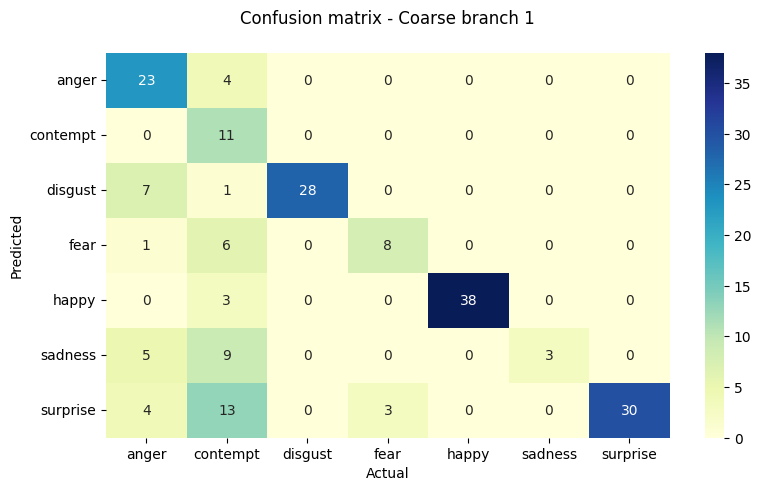

In [21]:
STEP_SIZE_TEST=test_set.n//test_set.batch_size
test_set.reset()
pred=model.predict(test_set,
                   steps=STEP_SIZE_TEST,
                   verbose=1)

# Get the number of unique labels
num_labels = len(np.unique(test_set.classes))

predicted_class_indices=np.argmax(pred[0],axis=1)

# Define a list of label names
label_names = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']

# Compute the accuracy for each label
label_accs = {}
for label in range(num_labels):
    idx = np.where(test_set.classes == label)[0]
    label_acc = np.mean(predicted_class_indices[idx] == test_set.classes[idx])
    label_accs[label_names[label]] = label_acc

# Print the accuracy for each label
for label, acc in label_accs.items():
    print(f"Accuracy for label {label}: {acc:.2f}")
print("\n")

# labels = (training_set.class_indices)
# labels = dict((v,k) for k,v in labels.items())
# predictions = [labels[k] for k in predicted_class_indices]

from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

plt.figure(figsize=(20, 5))

# Make predictions on the test set
# y_pred = model.predict(test_set)

# Get the true labels for the test set
y_true = test_set.classes

# Compute the confusion matrix
conf_mat = confusion_matrix(y_true, predicted_class_indices)

df_cm = pd.DataFrame(conf_mat, index=['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise'], 
                     columns=['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise'])
plt.subplot(121)
plt.title("Confusion matrix - Coarse branch 1\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")

from sklearn.metrics import classification_report

# Assuming y_true and y_pred are the true and predicted labels
report = classification_report(y_true, predicted_class_indices)
print(report)

Accuracy for label anger: 1.00
Accuracy for label contempt: 1.00
Accuracy for label disgust: 1.00
Accuracy for label fear: 0.93
Accuracy for label happy: 0.95
Accuracy for label sadness: 0.88
Accuracy for label surprise: 1.00


              precision    recall  f1-score   support

           0       0.96      1.00      0.98        27
           1       0.73      1.00      0.85        11
           2       1.00      1.00      1.00        36
           3       1.00      0.93      0.97        15
           4       1.00      0.95      0.97        41
           5       1.00      0.88      0.94        17
           6       1.00      1.00      1.00        50

    accuracy                           0.97       197
   macro avg       0.96      0.97      0.96       197
weighted avg       0.98      0.97      0.98       197



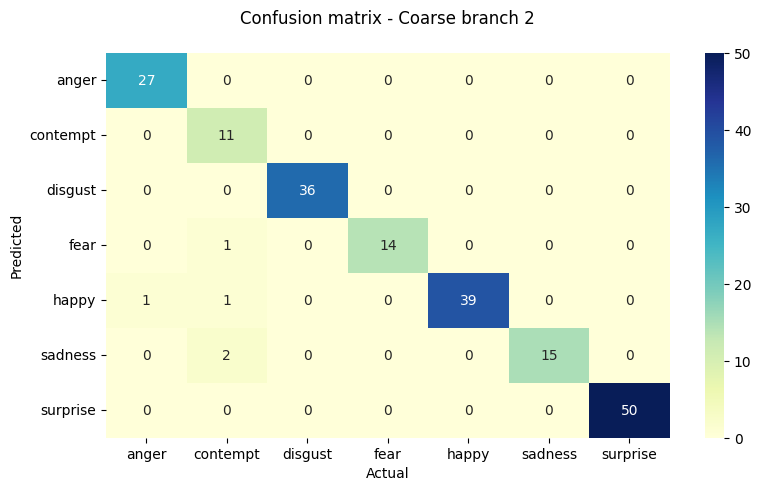

In [22]:
predicted_class_indices=np.argmax(pred[1],axis=1)

# Define a list of label names
# label_names = ['Closed', 'no_yawn', 'Open', 'yawn']

# Compute the accuracy for each label
label_accs = {}
for label in range(num_labels):
    idx = np.where(test_set.classes == label)[0]
    label_acc = np.mean(predicted_class_indices[idx] == test_set.classes[idx])
    label_accs[label_names[label]] = label_acc

# Print the accuracy for each label
for label, acc in label_accs.items():
    print(f"Accuracy for label {label}: {acc:.2f}")
print("\n")

from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

plt.figure(figsize=(20, 5))

# Make predictions on the test set
# y_pred = model.predict(test_set)

# Get the true labels for the test set
y_true = test_set.classes

# Compute the confusion matrix
conf_mat = confusion_matrix(y_true, predicted_class_indices)

df_cm = pd.DataFrame(conf_mat, index=['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise'], 
                     columns=['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise'])
plt.subplot(121)
plt.title("Confusion matrix - Coarse branch 2\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")

from sklearn.metrics import classification_report

# Assuming y_true and y_pred are the true and predicted labels
report = classification_report(y_true, predicted_class_indices)
print(report)

Accuracy for label anger: 0.93
Accuracy for label contempt: 1.00
Accuracy for label disgust: 1.00
Accuracy for label fear: 1.00
Accuracy for label happy: 1.00
Accuracy for label sadness: 1.00
Accuracy for label surprise: 1.00


              precision    recall  f1-score   support

           0       1.00      0.93      0.96        27
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00        36
           3       1.00      1.00      1.00        15
           4       1.00      1.00      1.00        41
           5       0.89      1.00      0.94        17
           6       1.00      1.00      1.00        50

    accuracy                           0.99       197
   macro avg       0.98      0.99      0.99       197
weighted avg       0.99      0.99      0.99       197



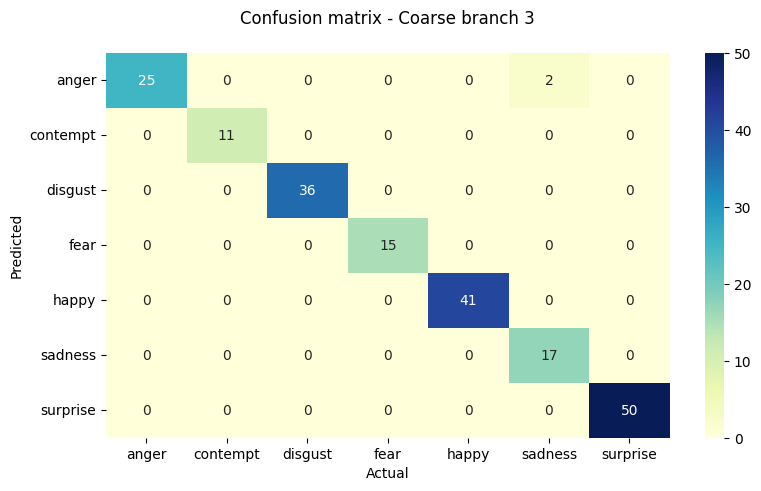

In [23]:
predicted_class_indices=np.argmax(pred[2],axis=1)

# Define a list of label names
# label_names = ['Closed', 'no_yawn', 'Open', 'yawn']

# Compute the accuracy for each label
label_accs = {}
for label in range(num_labels):
    idx = np.where(test_set.classes == label)[0]
    label_acc = np.mean(predicted_class_indices[idx] == test_set.classes[idx])
    label_accs[label_names[label]] = label_acc

# Print the accuracy for each label
for label, acc in label_accs.items():
    print(f"Accuracy for label {label}: {acc:.2f}")
print("\n")

from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

plt.figure(figsize=(20, 5))

# Make predictions on the test set
# y_pred = model.predict(test_set)

# Get the true labels for the test set
y_true = test_set.classes

# Compute the confusion matrix
conf_mat = confusion_matrix(y_true, predicted_class_indices)

df_cm = pd.DataFrame(conf_mat, index=['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise'], 
                     columns=['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise'])
plt.subplot(121)
plt.title("Confusion matrix - Coarse branch 3\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")

from sklearn.metrics import classification_report

# Assuming y_true and y_pred are the true and predicted labels
report = classification_report(y_true, predicted_class_indices)
print(report)

Accuracy for label anger: 1.00
Accuracy for label contempt: 1.00
Accuracy for label disgust: 1.00
Accuracy for label fear: 1.00
Accuracy for label happy: 1.00
Accuracy for label sadness: 0.94
Accuracy for label surprise: 1.00


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       0.92      1.00      0.96        11
           2       1.00      1.00      1.00        36
           3       1.00      1.00      1.00        15
           4       1.00      1.00      1.00        41
           5       1.00      0.94      0.97        17
           6       1.00      1.00      1.00        50

    accuracy                           0.99       197
   macro avg       0.99      0.99      0.99       197
weighted avg       1.00      0.99      0.99       197



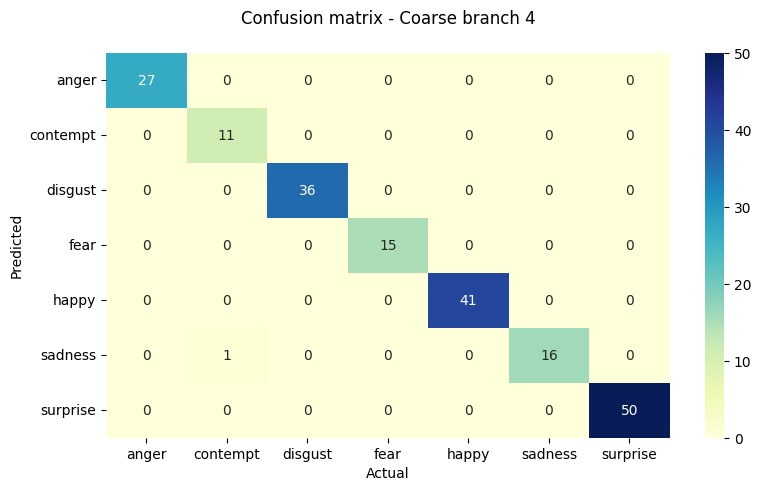

In [24]:
predicted_class_indices=np.argmax(pred[3],axis=1)

# Define a list of label names
# label_names = ['Closed', 'no_yawn', 'Open', 'yawn']

# Compute the accuracy for each label
label_accs = {}
for label in range(num_labels):
    idx = np.where(test_set.classes == label)[0]
    label_acc = np.mean(predicted_class_indices[idx] == test_set.classes[idx])
    label_accs[label_names[label]] = label_acc

# Print the accuracy for each label
for label, acc in label_accs.items():
    print(f"Accuracy for label {label}: {acc:.2f}")
print("\n")

from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

plt.figure(figsize=(20, 5))

# Make predictions on the test set
# y_pred = model.predict(test_set)

# Get the true labels for the test set
y_true = test_set.classes

# Compute the confusion matrix
conf_mat = confusion_matrix(y_true, predicted_class_indices)

df_cm = pd.DataFrame(conf_mat, index=['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise'], 
                     columns=['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise'])
plt.subplot(121)
plt.title("Confusion matrix - Coarse branch 4\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")

from sklearn.metrics import classification_report

# Assuming y_true and y_pred are the true and predicted labels
report = classification_report(y_true, predicted_class_indices)
print(report)

Accuracy for label anger: 1.00
Accuracy for label contempt: 1.00
Accuracy for label disgust: 1.00
Accuracy for label fear: 1.00
Accuracy for label happy: 1.00
Accuracy for label sadness: 0.94
Accuracy for label surprise: 1.00


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00        36
           3       0.94      1.00      0.97        15
           4       1.00      1.00      1.00        41
           5       1.00      0.94      0.97        17
           6       1.00      1.00      1.00        50

    accuracy                           0.99       197
   macro avg       0.99      0.99      0.99       197
weighted avg       1.00      0.99      0.99       197



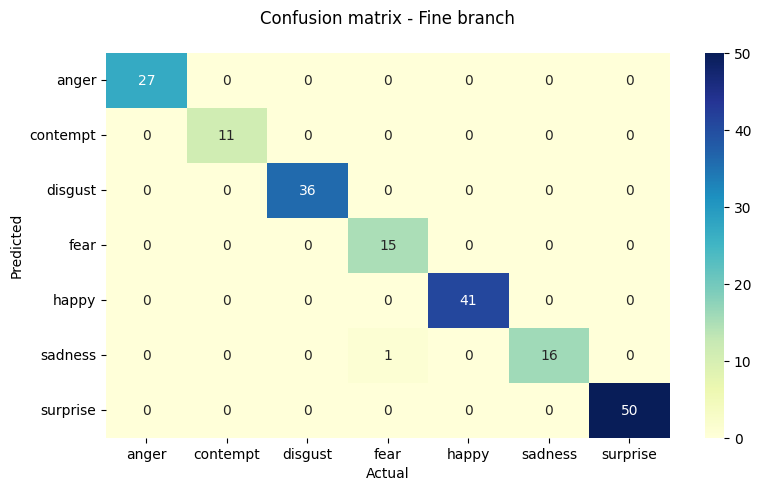

In [25]:
predicted_class_indices=np.argmax(pred[4],axis=1)

# Define a list of label names
# label_names = ['Closed', 'no_yawn', 'Open', 'yawn']

# Compute the accuracy for each label
label_accs = {}
for label in range(num_labels):
    idx = np.where(test_set.classes == label)[0]
    label_acc = np.mean(predicted_class_indices[idx] == test_set.classes[idx])
    label_accs[label_names[label]] = label_acc

# Print the accuracy for each label
for label, acc in label_accs.items():
    print(f"Accuracy for label {label}: {acc:.2f}")
print("\n")

from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

plt.figure(figsize=(20, 5))

# Make predictions on the test set
# y_pred = model.predict(test_set)

# Get the true labels for the test set
y_true = test_set.classes

# Compute the confusion matrix
conf_mat = confusion_matrix(y_true, predicted_class_indices)

df_cm = pd.DataFrame(conf_mat, index=['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise'], 
                     columns=['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise'])
plt.subplot(121)
plt.title("Confusion matrix - Fine branch\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")

from sklearn.metrics import classification_report

# Assuming y_true and y_pred are the true and predicted labels
report = classification_report(y_true, predicted_class_indices)
print(report)